[Last chapter](../03_oner/oner.ipynb) we implemented the OneR [@Holte1993] algorithm. In this chapter we'll improve the model without improving the model. Sounds strange, but bear with me. This chapter is all about changing the input to the model.

Right now we just pass in the review as input. It's a string and every review is unique. The review is treated as a category where each unique review is it's own category. Before training, each unique review is assigned a number to represent it.

With this setup, the only way to compare two reviews is to see if they are the same review or not. But two pieces of text contain much richer information that can be used to compare them. Letters make up words, words make up sentences, sentences make up paragraphs, and so on. Language also has syntax and semantics. As machine learning practitioners we actually don't care about syntax and semantics. We expect our models will learn the concepts they need as they train on the target task. We do care about how the text is represented as this is what our models learn from. Our model currently learns from a single number that represents a review. Let's change that.

## Feature extraction

Feature extraction is a way to convert data into a format that is useable by machine learning models. Data that is numeric, like scientific measurements, are machine learning friendly by default, but text and image data is not. These types of data need to be converted to numbers in a way that preserves their information. Last chapter we converted our text data to numbers, but we didn't preserve any of the information in the reviews and ended up with a model that performed the same as the baseline.

We'll try again, but while preserving some of the information in the text. As always, let's start simple.

### Bag of characters

We have reviews. These are just sentences, which are just words, which are just characters. So reviews are characters. We can count the number of each character in a review and represent the review as character counts. This is representation is called a bag of characters and it can be extended to words, sentences, or whatever you want really. And of course `sklearn` has a way to do this.[`CountVectotrizer` returns a [sparse matrix](https://docs.scipy.org/doc/scipy/reference/sparse.html) which are memory efficient for matrices that contain mostly 0s.]{.aside}

In [1]:
from nlpbook import get_train_test_data
from sklearn.feature_extraction.text import CountVectorizer

train_df, test_df = get_train_test_data()

# Create the bag of characters feature extraction transformer.
# The `CountVectorizer` class bags input text. We set
# `analyzer="char"` so that `CountVectorizer` counts characters
# instead of words and `lowercase=False` to prevent upper case
# letters from being converted to lowercase.
vectorizer = CountVectorizer(analyzer="char", lowercase=False)

# Fit the bag of characters transformer on our reviews.
# Notice we do not pass a matrix into the fit method, but an array.
# Feature extraction should be performed on a per column basis so
# we need to pass in the column we want feature extraction performed
# on.
vectorizer.fit(train_df["review"])

# Transform the first row to a bag of characters.
# Convert the sparse matrix to a numpy array to see the counts.
vectorizer.transform(train_df["review"].head(1)).toarray()

array([[  0,   0,   0, 275,   0,   6,   0,   0,   0,   1,   5,   1,   1,
          0,   0,  25,   4,  16,   8,   0,   2,   0,   0,   0,   0,   0,
          0,   1,   2,   0,   0,   8,   0,   8,   0,   0,   2,   5,   0,
          1,   0,   0,   3,   2,   3,   0,   0,   3,   5,   2,   1,   1,
          0,   2,   1,   5,   1,   0,   3,   0,   0,   0,   0,   0,   0,
          0,   0,   0,  99,  24,  23,  50, 166,  31,  21,  64,  84,   1,
          5,  61,  27,  89,  92,  30,   1,  94,  90, 122,  29,  13,  17,
          0,  35,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0

We can check what character each array element is counting with the `vocabulary_` dict.

In [2]:
list(vectorizer.vocabulary_.items())[:5]

[('"', 5), ('N', 49), ('a', 68), ('t', 87), ('i', 76)]

So index 5 of the above array is the counts for the character `"` and index 49 is the counts for `N`.

## OneR revisited

Now we can just pass this as input to our OneR model right? Not quite, our model isn't capable of handling this input yet. Here's the implementation from last chapter.

In [3]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.dummy import DummyClassifier
from sklearn.utils.validation import validate_data


class OneR(ClassifierMixin, BaseEstimator):
    def fit(self, X, y):
        """Find the most predictive rule."""
        # Sanity check on `X` and `y`.
        X, y = validate_data(self, X, y)
        predictors = {}
        # Get the unique categories from the first column.
        categories = np.unique(X[:, 0])
        for category in categories:
            # Create a conditional array where each index
            # is a boolean indicating if that index in the
            # first column of `X` is the category we're iterating
            # over.
            is_category = X[:, 0] == category
            # Grab all data points and labels in this category.
            _X = X[is_category]
            _y = y[is_category]
            # Train a baseline classifier on the category.
            predictors[category] = DummyClassifier().fit(_X, _y)
        self.predictors_ = predictors
        # Create a fallback predictor for unknown categories.
        self.unknown_predictor_ = DummyClassifier().fit(X, y)
        return self

    def predict(self, X):
        """Predict the labels for inputs `X`."""
        # Sanity check on `X`.
        # `reset` should be `True` in `fit` and `False` everywhere else.
        X = validate_data(self, X, reset=False)
        # Create an empty array that will hold the predictions.
        rv = np.zeros(X.shape[0])
        # Get the unique categories from the first column.
        categories = np.unique(X[:, 0])
        for category in categories:
            # Create a conditional array where each index
            # is a boolean indicating if that index in the
            # first column of `X` is the category we're iterating
            # over.
            is_category = X[:, 0] == category
            # Grab all data points in this category.
            _X = X[is_category]
            # Predict the label for all datapoints in `_X`.
            try:
                predictions = self.predictors_[category].predict(_X)
            except KeyError:
                # Fallback to the predictor for unknown categories.
                predictions = self.unknown_predictor_.predict(_X)
            # Assign the prediction for this category to
            # the corresponding indices in `rv`.
            rv[is_category] = predictions
        return rv

Notice the model only looks at the first column. If we use it now it will use the counts in the first column of our bag of characters matrix for training and prediction which isn't what we want.

Previously, I said the algorithm works by predicting the most frequent label for each category, but in reality it only does this for _one feature_, hence the name OneR which stands for One Rule. The model finds the feature whose categories are most predictive of the training data, then predicts labels based on just that feature. When we first implemented this model we only had one feature so it didn't matter, but now we have many, so we need to tweak the implementation to find the best feature when given any number of features.

In [4]:
import scipy.sparse

# Rename the `OneR` class to `Rule`.
Rule = OneR


# Create a new `OneR` class which finds the best `Rule` in the
# dataset.
class OneR(ClassifierMixin, BaseEstimator):
    def fit(self, X, y):
        """Find the best rule in the dataset."""
        # Sanity check on `X` and `y`.
        X, y = validate_data(self, X, y, accept_sparse=True)

        col_idx = score = rule = None
        # Iterate over the indices for each column in X.
        for i in range(X.shape[1]):
            # Create a new matrix containing just the ith column.
            _X = X[:, [i]]
            # Convert sparse matrix to `numpy` array.
            # `Rule` works on numpy arrays, so we should use consistent
            # array types.
            if scipy.sparse.issparse(_X):
                _X = _X.toarray()

            # Create a rule for the ith column.
            rule_i = Rule().fit(_X, y)
            # Score the ith columns accuracy.
            score_i = rule_i.score(_X, y)

            # Keep the rule for the ith column if it has the highest
            # accuracy so far.
            if score is None or score_i > score:
                rule = rule_i
                score = score_i
                col_idx = i

        self.rule_ = rule
        self.i_ = col_idx
        return self

    def predict(self, X):
        """Predict the labels for inputs `X`."""
        # Sanity check on `X`.
        X = validate_data(self, X, reset=False, accept_sparse=True)
        _X = X[:, [self.i_]]
        # Convert sparse matrix to `numpy` array.
        # `Rule` works on numpy arrays, so we should use consistent
        # array types.
        if scipy.sparse.issparse(_X):
            _X = _X.toarray()

        # Return predictions for the rule.
        return self.rule_.predict(_X)

And now we can train the model! [[`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) is a handy utility for applying transforms to specific columns of a dataframe.]{.aside}

In [5]:
# | output: false
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Grab `X` and `y`.
features = ["review"]
labels = "label"
X, y = train_df[features], train_df[labels]

# Create the bag of characters transform.
bag_of_chars = CountVectorizer(analyzer="char", lowercase=False)

# Wrap the bag of characters transform in a `ColumnTransformer`.
# This class lets us perform transforms on specific columns of a
# `DataFrame` instead of on the entire `DataFrame`. This allows
# us to use `CountVectorizer` on just the "review" column.
# Check the docs link in the margin.
column_transform = ColumnTransformer(
    [("bag_of_chars", bag_of_chars, "review")]
)

oner = OneR()

# Create our pipeline.
pipeline = Pipeline([("bag_chars", column_transform), ("oner", oner)])

# Train it!
pipeline.fit(X, y)

Pipeline(steps=[('bag_chars',
                 ColumnTransformer(transformers=[('bag_of_chars',
                                                  CountVectorizer(analyzer='char',
                                                                  lowercase=False),
                                                  'review')])),
                ('oner', OneR())])

Now after all that work, how'd we do?

In [6]:
X_test, y_test = test_df[features], test_df[labels]
pipeline.score(X_test, y_test)

0.5812817904374364

58% accuracy, that's a big improvement over the 50% accuracy of our baseline and original OneR models! All we did was change the input to the OneR model and we gained an 8% bump in accuracy.

## Machine learning is an end to end process

We barely touched the model and ended up with an 8% improvement just by improving the preprocessing step. There are multiple steps to building a model, from collecting data through model training and they are all important for the final outcome. I probably sound like a broken record at this point, but this is why we started with a baseline model. The process of building a model is really one of experimentation. You make a change here then test it. Now a change there and test it. It's tweak after tweak, but you need to know how those tweaks affect the performance.

## Models as analysis tools

Now that we've trained a model that actually has some predictive power, we can start to use it for interesting things. Often we use models to predict outcomes, but we can also go in the other direction and use them to learn about our data. OneR found some character that is predictive for our data. What is that character?

In [7]:
# Get the index of the rule.
bag_idx = oner.i_

# Grab the vocabulary from the fitted bag of characters.
vocab = column_transform.named_transformers_.bag_of_chars.vocabulary_

# Find the character associated with the index.
[char for char, char_idx in vocab.items() if char_idx == bag_idx]

['?']

Interesting, question marks are the most important character for determining labels. My hypothesis is more question marks means a bad review.

<Axes: xlabel='?', ylabel='count'>

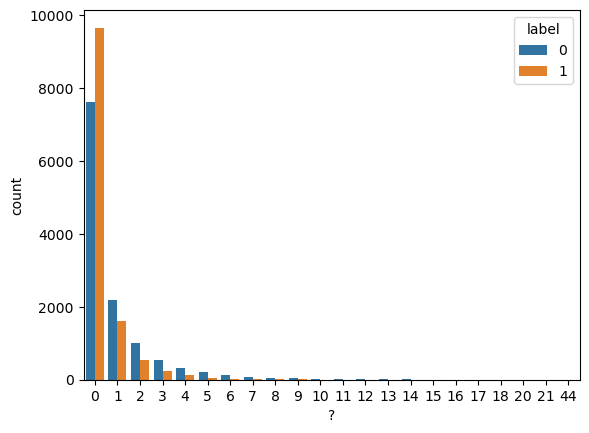

In [8]:
import seaborn as sns

data = X_test.copy()
data["?"] = column_transform.transform(X_test)[:, bag_idx].toarray()
data["label"] = y_test
sns.countplot(data, x="?", hue="label")

Ah, so if there are no question marks, the review is more likely to be positive. Inversely we can say if the review contains a question, it's likely the review is negative.

Instead of analyzing the data ourselves to find which characters are associated with positive or negative reviews, our model did the analysis for us. We let the model learn about the data, then in turn we leveraged what the model learned to gain an insight into the data. As we make better models and richer representations of the input text, the amount of information we'll learn about the data will increase as well.

## Rolling our own feature extractor

We've already handled the OneR model, now let's make a bag of characters transformer.

In [9]:
from sklearn.base import TransformerMixin


class BagOfChars(TransformerMixin, BaseEstimator):
    """Bag of characters feature extractor."""

    def fit(self, X, y=None):
        """Fit on all characters in the array `X`.

        Note: `X` should be a 1d array.
        """
        # We run our own validation check since `validate_data`
        # expects a 2d numberic array.
        # We want a 1d text array so we'll check its shape here.
        # While iterating over the array values we'll check
        # they are text while trying to extract characters.
        assert len(X.shape) == 1

        vocabulary_ = {}
        # Iterate over each string in the array.
        for x in X:
            # Check it's a string!
            assert isinstance(x, str)
            # Get the unique characters in the string.
            chars = np.unique(list(x))
            # Add each character to the vocabulary if it isn't
            # there already.
            for char in chars:
                if char not in vocabulary_:
                    vocabulary_[char] = len(vocabulary_)
        self.vocabulary_ = vocabulary_
        return self

    def transform(self, X):
        """Transform `X` to a count matrix.

        Note: `X` should be a 1d array.
        """
        # Run our own checks.
        assert len(X.shape) == 1
        # Check we fit the instance.
        assert hasattr(self, "vocabulary_")

        # Create a matrix to hold the counts.
        rv = np.zeros((X.shape[0], len(self.vocabulary_)))
        # Iterate over each string in the array.
        for i, x in enumerate(X):
            # Check it's a string!
            assert isinstance(x, str)
            # Get the unique characters in the string and their
            # counts.
            chars, counts = np.unique(list(x), return_counts=True)
            # Add each character count to the count matrix
            # for the specific row.
            for char, count in zip(chars, counts):
                # Make sure the character is part of the vocabulary,
                # otherwise ignore it.
                if char in self.vocabulary_:
                    rv[i, self.vocabulary_[char]] = count
        # Return the count matrix.
        return rv


# Let's plug it into the pipeline and see how it goes.
column_transform = ColumnTransformer(
    [("bag_of_chars", BagOfChars(), "review")]
)

oner = OneR()

# Create our pipeline.
pipeline = Pipeline([("bag_chars", column_transform), ("oner", oner)])

# Train it!
pipeline.fit(X, y)
pipeline.score(X_test, y_test)

0.5812817904374364

Easy peasy.

## Multiclass classification

Let's see how we do with multiclass classification. Our accuracy with the baseline model was 20%. Can we beat that?

In [10]:
y_multi = train_df["rating"]
y_test_multi = test_df["rating"]

pipeline.fit(X, y_multi)
pipeline.score(X_test, y_test_multi)

0.19377416073245168

It's about the same, that's unfortunate. This is a harder problem than predicting if a review is positive or negative. The decision of what class to choose is more complicated since there's more options to choose from. With that added complexity, the model needs to learn more information about the data to be predictive. This means our model is either too simple or the input doesn't contain enough information to scale to this more difficult task. Performance on the multiclass classification problem will lag behind the binary classification problem, but it will improve as we build better and better models.